In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('fivethirtyeight')
%matplotlib inline

## Defining a Classifier

**Please run all cells before this cell, including the import cell at the top of the notebook.**

In [5]:
# On the original dataset drop column ID and create a new empty column Distance
patients = pd.read_csv('breast-cancer.csv')
patients = patients.drop(columns='ID')
patients['Distance'] = ""
patients

Clump Thickness  Uniformity of Cell Size  Uniformity of Cell Shape  \
0                  5                        1                         1   
1                  5                        4                         4   
2                  3                        1                         1   
3                  6                        8                         8   
4                  4                        1                         1   
..               ...                      ...                       ...   
678                3                        1                         1   
679                2                        1                         1   
680                5                       10                        10   
681                4                        8                         6   
682                4                        8                         8   

     Marginal Adhesion  Single Epithelial Cell Size  Bare Nuclei  \
0                    1                            2            1   
1                    5                            7           10   
2                    1                            2            2   
3                    1                            3            4   
4                    3                            2            1   
..                 ...                          ...          ...   
678                  1                            3            2   
679                  1                            2            1   
680                  3                            7            3   
681                  4                            3            4   
682                  5                            4            5   

     Bland Chromatin  Normal Nucleoli  Mitoses  Class Distance  
0                  3                1        1      0           
1                  3                2        1      0           
2                  3                1        1      0           
3                  3                7        1      0           
4                  3                1        1      0           
..               ...              ...      ...    ...      ...  
678                1                1        1      0           
679                1                1        1      0           
680                8               10        2      1           
681               10                6        1      1           
682               10                4        1      1           

[683 rows x 11 columns]

**
Let's try to visualize the data as a cluster chart. What happens is that there are many data points with exact same X and Y values and they end up overlapping and get displayed as a single dot in the below chart. How can we distinguish between these data points so that they are displayed as a small cluster instead?
**

In [6]:
# To create labels in the scatter diagram grouping by Class is needed.
patients_class_0 = patients.groupby(by='Class').get_group((0))
patients_class_1 = patients.groupby(by='Class').get_group((1))

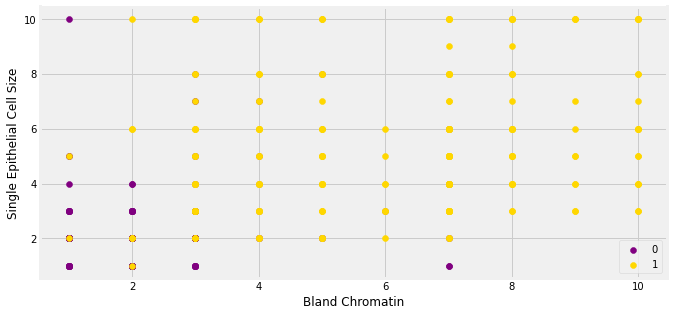

In [7]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(patients_class_0['Bland Chromatin'], patients_class_0['Single Epithelial Cell Size'], c='purple', label='0')
ax.scatter(patients_class_1['Bland Chromatin'], patients_class_1['Single Epithelial Cell Size'], c='gold', label='1')
ax.legend()
ax.set_xlabel('Bland Chromatin')
ax.set_ylabel('Single Epithelial Cell Size');

**
We can introduce a very tiny amount of random noise to each data point such that similar points don't overlap. Let's write a simple function! Note the RANDOMNESS of the noise being introduced on BOTH axes. 
**

In [8]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))

jittered = pd.DataFrame({'Bland Chromatin (jittered)': 
        randomize_column(patients['Bland Chromatin']), 'Single Epithelial Cell Size (jittered)': 
        randomize_column(patients['Single Epithelial Cell Size']), 'Class': patients['Class']})

In [9]:
jittered_class_0 = jittered.groupby(by='Class').get_group((0))
jittered_class_1 = jittered.groupby(by='Class').get_group((1))

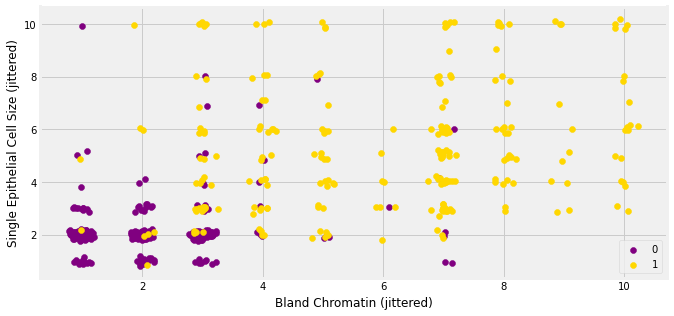

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(jittered_class_0['Bland Chromatin (jittered)'], jittered_class_0['Single Epithelial Cell Size (jittered)'], c='purple', label='0')
ax.scatter(jittered_class_1['Bland Chromatin (jittered)'], jittered_class_1['Single Epithelial Cell Size (jittered)'], c='gold', label='1')
ax.legend()
ax.set_xlabel('Bland Chromatin (jittered)')
ax.set_ylabel('Single Epithelial Cell Size (jittered)');

## Distance

**Please run all cells before this cell, including the previous example cells and the import cell at the top of the notebook.**

** 
Given two points, how can we establish a measure for their "closeness"? Hint: calculate Eucledian distance between them!!
**

Formula: SQRT((x2-x1)^2 + (y2-y1)^2))



In [11]:
a_table = pd.DataFrame({'X': [0, 2, 3], 'Y': [0, 2, 4]})
a_table

X  Y
0  0  0
1  2  2
2  3  4

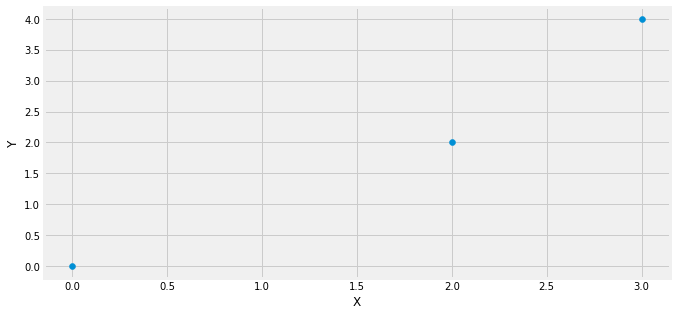

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(a_table['X'], a_table['Y'])
ax.set_xlabel('X')
ax.set_ylabel('Y');

In [13]:
def distance(row1, row2):
    """Return the distance between two points (represented as arrays)"""
    return np.sqrt(sum((row1 - row2) ** 2))

Training Set and Evaluation Set    
Giving a point to be classified, I have to compare it to the nearest one in the Training Set.

## Classification Procedure

**Please run all cells before this cell, including the previous example cells and the import cell at the top of the notebook.**

**
General strategy : For a given (unseen) example, find the distance between this new observation and all the available observations (one at a time), then take the top K observations that are closest to this new observation (smaller the distance, closer the two observations) and lable the unseen example with the class that is the majority among the chosen K-nearest observations.
**

In [16]:
def select_testing_training(table, nrows):
    """Return a tuple with indexes for Training and Testing Sets.
       Training Set takes a sample of NROWS from TABLE, and Testing Sets are the remaining rows."""
    testing_index = []
    training_index = table.sample(nrows).index
    for index in table.index:
        if index not in training_index:
            testing_index.append(index)
    testing_index = pd.Index(testing_index)
    return testing_index, training_index

In [29]:
def distances(table, example):
    "Return an array with the distances of each row in TABLE to EXAMPLE."
    dists = np.array([])
    train_rows, train_cols = table.shape
    for row in np.arange(train_rows):
        dist = distance(np.array(table.iloc[row])[:-2], example)
        dists = np.append(dists, dist)
    return dists

In [34]:
def get_knn(table, example, k):
    """Return the K nn for EXAMPLE in the Training TABLE."""
    table['Distance'] = distances(table, example)
    knn = table.sort_values(by='Distance').head(k)
    return knn

In [33]:
def majority_class(table, example , k):
    """Return the Class with the majority number in knn for Training TABLE
       ,EXAMPLE and K nn."""
    knn = get_knn(table, example, k)
    knn_grouped = knn.groupby(by='Class').aggregate({'Class' : 'count'})
    knn_grouped.columns = ['Count']
    major_class = knn_grouped.sort_values(by='Count', ascending=False).index[0]
    return major_class

In [30]:
testing_index , training_index = select_testing_training(patients, 600)

In [31]:
# Generate Training and Testing Sets
train_table = patients.iloc[training_index]
test_table = patients.iloc[testing_index]

In [32]:
# Select first row of Testing Set as an example
# Do not include Class or Distance column information
example = np.array(test_table.iloc[0])[:-2]
example

array([5, 4, 4, 5, 7, 10, 3, 2, 1], dtype=object)

In [35]:
majority_class(train_table, example, 5)

1

## Evaluation

**Please run all cells before this cell, including the previous example cells and the import cell at the top of the notebook.**

**
How can we validate that our classifier is "good"? We set aside a small portion of the given data as our test set, use remaining data to train our classifier and then test the classifier on our test set. A good measure of accuracy for our classifier will be the number of examples it predicted correctly in test set (meaning Predicted Value == Actual value).
**

In [ ]:
def gen_class_tables(orintable, nrows):
    "Return Training and Testing Sets from ORINTABLE with NROWS for Training."
    test_index, train_index = select_testing_training(orintable, nrows)
    train_table = orintable.iloc[train_index]
    test_table = orintable.iloc[test_index]
    return train_table, test_table

In [ ]:
def evaluate_accuracy(training, test, k):
    test_attributes = test.drop('Class')
    num_correct = 0
    for i in np.arange(test.num_rows):
        # Run the classifier on the ith patient in the test set
        test_patient = test_attributes.row(i)
        c = classify(training, test_patient, k)
        # Was the classifier's prediction correct?
        if c == test.column('Class').item(i):
            num_correct = num_correct + 1
    return num_correct / test.num_rows

In [ ]:
evaluate_accuracy(training_set, test_set, 5)

In [ ]:
evaluate_accuracy(training_set, test_set, 1)

In [ ]:
evaluate_accuracy(training_set, training_set, 1)

#### As we saw in the above cell, a 1-nearest neighbor classifier when tested on the training data itself will show 100% accuracy (of course it will! A data point is closest to itself after all!!). But that's very misleading and wrong! Never do that!!!

## Decision Boundaries

**Please run all cells before this cell, including the previous example cells and the import cell at the top of the notebook.**

In [ ]:
ckd = Table.read_table('ckd.csv').relabeled('Blood Glucose Random', 'Glucose')
ckd.show(3)

In [ ]:
kidney = ckd.select('Hemoglobin', 'Glucose', 'Class')
kidney.scatter('Hemoglobin', 'Glucose', colors=2)
plots.scatter(13, 250, color='red', s=30);

In [ ]:
def show_closest(t, point):
    """Show closest training example to a point."""
    near = closest(t, point, 1).row(0)
    t.scatter(0, 1, colors='Class')
    plots.scatter(point.item(0), point.item(1), color='red', s=30)
    plots.plot([point.item(0), near.item(0)], [point.item(1), near.item(1)], color='k', lw=2)
    
show_closest(kidney, make_array(13, 250))

**In the above chart, the point chosen as nearest is NOT ACTUALLY the nearest one (as we can visually confirm)! Why did that happen? It happened because the X and Y axes are at a different scale. The formula for calculating Eucledian distance is based on the difference between X as well as Y axes. In this case, for a relatively small change in X value around the example (red) point, Y changes significantly. Hence, the point with the OVERALL lowest distance is chosen (incorrectly) as the nearest one.
**

#### How can we fix this? Convert your data into STANDARD UNITS!!


In [ ]:
def standard_units(any_numbers):
    """Convert any array of numbers to standard units."""
    return (any_numbers - np.mean(any_numbers)) / np.std(any_numbers)

def standardize(t):
    """Return a table in which all columns of t are converted to standard units."""
    t_su = Table()
    for label in t.labels:
        t_su = t_su.with_column(label + ' (su)', standard_units(t.column(label)))
    return t_su

In [ ]:
kidney_su = standardize(kidney.drop('Class')).with_column('Class', kidney.column('Class'))
show_closest(kidney_su, make_array(-0.2, 1.8))

In [ ]:
show_closest(kidney_su, make_array(-0.2, 1.3))

In [ ]:
show_closest(kidney_su, make_array(-0.2, 1))

In [ ]:
show_closest(kidney_su, make_array(-0.2, 0.9))

**
How to draw the decision boundary? <br><br>
Method: Imagine every possible data point on the chart as an (x,y) pair. We use these points to draw a scatter chart and color it based on the predicted values first (light blue and light yellow). We'll get a nice separation between the two clusters and that's the decision boundary. Then we overlay the actual values (dark blue and dark yellow)  on top of this filled-out scatter plot to vislauize how the actual data looks. Changing the K-value will show a different decision boundary. Some will be smoother (more generalized) than the others (more edges/squiggly). More generalized ones are the goal for better predictions.
**

In [ ]:
def decision_boundary(t, k):
    """Decision boundary of a two-column + Class table."""
    t_su = standardize(t.drop('Class')).with_column('Class', t.column('Class')) # Can't standardize class, so exclude.
    decisions = Table(t_su.labels)
    for x in np.arange(-2, 2.1, 0.1):
        for y in np.arange(-2, 2.1, 0.1):
            predicted = classify(t_su, make_array(x, y), k)
            decisions.append([x, y, predicted])
    decisions.scatter(0, 1, colors='Class', alpha=0.4)
    plots.xlim(-2, 2)
    plots.ylim(-2, 2)
    t_su_0 = t_su.where('Class', 0)
    t_su_1 = t_su.where('Class', 1)
    plots.scatter(t_su_0.column(0), t_su_0.column(1), c='darkblue', edgecolor='k')
    plots.scatter(t_su_1.column(0), t_su_1.column(1), c='gold', edgecolor='k')
    
decision_boundary(kidney, 1)

In [ ]:
decision_boundary(kidney, 5)

In [ ]:
decision_boundary(jittered, 1)

In [ ]:
decision_boundary(jittered, 5)